In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

from moviepy.editor import VideoFileClip

%matplotlib inline

In [17]:
def read_img(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [18]:
class CameraCalibration(object):
    def __init__(self):
        self.mtx = None
        self.dist = None
        
    def calibrate(self, chesboard_files):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.
    
        # Step through the list and search for chessboard corners
        for fname in chesboard_files:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
    
        # Get undistortion parameters
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

        self.mtx = mtx
        self.dist = dist
        
    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

In [176]:
class PerspectiveWarping(object):
    def __init__(self):
        
        # track 1 ROI
        w = 0 # to adjust the position
        width = 100
        self.roi = np.array([
            [60 + w, 680], # bottom left corner
            [640 + w - width, 460], # upper left corner
            [640 + w + width, 460], # upper right corner
            [1220 + w, 680] # bottom right corner
        ], np.float32)
        '''
        # track 2 ROI
        w = 0 # to adjust the position
        width = 140
        bx = 180
        self.roi = np.array([
            [bx + 40, 680], # bottom left corner
            [640 + 50 - width, 490], # upper left corner
            [640 + w + width, 490], # upper right corner
            [1280 - bx, 680] # bottom right corner
        ], np.float32)
        '''

        self.dst_height = 200
        self.dst_width = 200
        self.dst = np.array([
            [0, self.dst_height],
            [0, 0],
            [self.dst_width, 0],
            [self.dst_width, self.dst_height],
        ], np.float32)

        self.M = cv2.getPerspectiveTransform(self.roi, self.dst)
        self.inv_M = cv2.getPerspectiveTransform(self.dst, self.roi)
        
    def warp(self, img, is_dry=False):
        if is_dry:
            cv2.polylines(img, [self.roi.astype('int32')], True, (0, 255, 0), 4)
            return img
        return cv2.warpPerspective(img, self.M, (self.dst_width, self.dst_height), flags=cv2.INTER_LINEAR)
    
    def unwarp(self, img, width, height):
        return cv2.warpPerspective(img, self.inv_M, (width, height), flags=cv2.INTER_LINEAR)

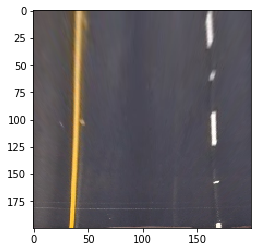

In [177]:
img = read_img("test_images/straight_lines1.jpg")
pw = PerspectiveWarping()
plt.imshow(pw.warp(img))

In [178]:
class GradientCalc(object):
    def __init__(self):
        self.sobel_kernel = 11
        self.mag_thresh = (20, 255)
        self.dir_thresh = (0, np.pi/8)
        
    def mag_threshold(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
        smoothed_img = cv2.GaussianBlur(img, (3, 3), 0)
        # Take the gradient in x and y separately
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)
        magnitude = np.sqrt(sobel_x ** 2)# + sobel_y ** 2)
        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled = np.uint8(magnitude * 255 / np.max(magnitude))
        # Create a binary mask where mag thresholds are met
        binary_output = np.zeros_like(scaled)
        binary_output[(scaled > self.mag_thresh[0]) & (scaled < self.mag_thresh[1])] = 1
        # Return this mask as your binary_output image
        return binary_output
    
    def dir_threshold(self, img):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
        # Take the gradient in x and y separately
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)
        # Take the absolute value of the x and y gradients
        abs_sobel_x = np.absolute(sobel_x)
        abs_sobel_y = np.absolute(sobel_y)
        # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        directions = np.arctan2(abs_sobel_y, abs_sobel_x) 
        # Create a binary mask where direction thresholds are met
        binary_output = np.zeros_like(directions)
        binary_output[(directions > self.dir_thresh[0]) & (directions < self.dir_thresh[1])] = 1
        # Return this mask as your binary_output image
        return binary_output
    
    def get_gradients(self, img):
        mags = self.mag_threshold(img)
        dirs = self.dir_threshold(img)
        combined = np.zeros_like(mags)
        combined[(dirs == 1) & (mags == 1)] = 1
        
        kernel = np.ones((3, 1), np.uint8)
        erosion = cv2.erode(combined, kernel,iterations = 1)
        
        kernel = np.ones((3, 11),np.uint8)
        dilate = cv2.dilate(erosion, kernel)
        
        return dilate

In [179]:
class LaneFinder(object):
    def __init__(self):
        self.nwindows = 9
        self.margin = 20
        self.minpix = 25
        self.left_fit = None
        self.right_fit = None
    
    def find_lanes(self, binary_warped, proc):
        #self.left_fit = None
        #self.right_fit = None
        
        flag = False
        if flag and self.left_fit is not None and self.right_fit is not None:
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            left_lane_inds = (
                (nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] - self.margin))
                & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] + self.margin))) 
            right_lane_inds = (
                (nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] - self.margin))
                & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] + self.margin)))  
        
        if not flag:
            histogram = np.sum(binary_warped, axis=0)
            histogram[60:140] = 0
            #histogram = gaussian_filter(histogram, sigma=3)
    
            # get the lanes
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/self.nwindows)
        
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
        
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
    
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []
        
            # Step through the windows one by one
            for window in range(self.nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - self.margin
                win_xleft_high = leftx_current + self.margin
                win_xright_low = rightx_current - self.margin
                win_xright_high = rightx_current + self.margin
        
                # Draw the windows on the visualization image
                cv2.rectangle(proc,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
                cv2.rectangle(proc,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = (
                    (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                    & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = (
                    (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                    & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
        
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > self.minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > self.minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        if len(leftx) and len(lefty):
            self.left_fit = np.polyfit(lefty, leftx, 2)
        else:
            self.left_fit = None
            leftx = None
            lefty = None
        
        if len(righty) and len(rightx):
            self.right_fit = np.polyfit(righty, rightx, 2)
        else:
            self.right_fit = None
            rightx = None
            righty = None
    
        return self.left_fit, self.right_fit, leftx, lefty, rightx, righty

In [180]:
class Line(object):
    def __init__(self, fit_len=2):
        self.left_fit = []
        self.right_fit = []
        self.fit_len = fit_len
        
    def append(self, fits):
        if fits[0] is not None:
            if len(self.left_fit) == self.fit_len:
                self.left_fit = self.left_fit[1:]
            self.left_fit.append(fits[0])
        
        if fits[1] is not None:
            if len(self.right_fit) == self.fit_len:
                self.right_fit = self.right_fit[1:]
            self.right_fit.append(fits[1])
        
    def get_fits(self):
        avg_left = np.mean(self.left_fit, 0)
        avg_right = np.mean(self.right_fit, 0)
        return avg_left, avg_right

In [181]:
class LineDrawer(object):
    def draw_lines(self, binary_warped, left_fit, right_fit):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        return color_warp

In [312]:
class Position(object):
    def __init__(self, size):
        self.size = 1
        self.positions = []
    
    def get_position(self, binary_warped, left_fit, right_fit):
        #if leftx is None or rightx is None:
         #   return 0
            
        if len(self.positions) == self.size:
            self.positions = self.positions[1:]
            
        # meters per pixel in x dimension
        xm_per_pix = 3.7/135
       
        # calculate the position near the bottom of the image (near car)
        near_car_pos = 200
        left_line = left_fit[0] * near_car_pos ** 2 + left_fit[1] * near_car_pos + left_fit[2]
        right_line = right_fit[0] * near_car_pos ** 2 + right_fit[1] * near_car_pos + right_fit[2]
        
        # the actual center of the warped image
        warped_center = binary_warped.shape[0]/2 
        
        # calculated center of the lane
        calc_center = (left_line + right_line)/2
        
        # calculate the offset
        lane_off = calc_center - warped_center
        
        return lane_off * xm_per_pix

In [327]:
 class CurvatureEstimator(object):
    def __init__(self, size):
        self.size = size
        self.curvatures = []
    
    def get_curvature(self, binary_warped, leftx, lefty, rightx, righty):#, rightx, righty):
        if leftx is None or rightx is None:
            if len(self.curvatures):
                return np.mean(self.curvatures)
            else:
                return 0
            
        if len(self.curvatures) == self.size:
            self.curvatures = self.curvatures[1:]
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 3/35 # meters per pixel in y dimension
        xm_per_pix = 3.7/135 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radius of curvature
        y_eval = 200
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        curvature = (left_curverad + right_curverad)/2
        self.curvatures.append(curvature)
        
        res = np.mean(self.curvatures)
        return res if res < 1500 else 0

In [328]:
class ColorSegmentation(object):
    def select(self, img, thresh, is_hls=False):
        smoothed_img = cv2.GaussianBlur(img, (3, 3), 0)
        if is_hls:
            smoothed_img = cv2.cvtColor(smoothed_img, cv2.COLOR_RGB2HLS)
            channel = smoothed_img[:,:,2]
            percentile = np.percentile(channel, 95)
        else:
            channel = smoothed_img[:,:,0]
            percentile = np.percentile(channel, 95)
        binary_mask = np.zeros_like(channel)
        binary_mask[(channel > percentile) & (channel <= thresh[1])] = 1
        return binary_mask
    
    def color_filter(self, image):
        
        yellow_lower = np.array([18, 25, 120])
        yellow_upper = np.array([45, 255, 255])
        white_sensitivity = 55
       
        white_lower = np.array([0, 0, 255 - white_sensitivity])
        white_upper = np.array([255, white_sensitivity, 255])
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        yellow_range = cv2.inRange(hsv, yellow_lower, yellow_upper)
        white_range = cv2.inRange(hsv, white_lower, white_upper)
        
        return cv2.bitwise_or(yellow_range, white_range)
    
    def select_color(self, img, rgb_thresh=(250, 255), hls_thresh=(100, 255)):
        rgb = self.select(img, rgb_thresh)
        hls = self.select(img, hls_thresh, True)
        combined = np.zeros_like(rgb)
        combined[(rgb == 1) | (hls == 1)] = 1
        return rgb

In [329]:
from scipy import signal

class ImageFilter(object):
        
    def gaussian(self, sigma, size):
        return signal.gaussian(
                size, std=sigma, sym=True)/(np.sqrt(2 * np.pi * sigma ** 2))
        
    def filter(self, img):
        x_M = 23
        x_larger_gaussian = self.gaussian(10, x_M)
        x_smaller_gaussian = self.gaussian(2, x_M)
        x_DoG = x_smaller_gaussian - x_larger_gaussian
        x_DoG = x_DoG[None]
        
        smoothed_img_x = cv2.filter2D(img, -1, kernel=x_DoG)
        deriv_img = scipy.ndimage.filters.gaussian_filter1d(smoothed_img_x, 3, axis=1, order=2)
        
        no_of_windows = 2
        windows_h = img.shape[1] // no_of_windows
        binary = np.zeros_like(deriv_img)
        
        for w in range(0, no_of_windows):
            window = deriv_img[w*windows_h:(w + 1)*windows_h,:,]
            per = np.percentile(window, 85)
            binary[w*windows_h:(w + 1)*windows_h,:][window > per] = 1
            
        kernel = np.ones((2, 2),np.uint8)
        binary = cv2.dilate(binary, kernel,iterations = 1)
        return smoothed_img_x, binary      

In [330]:
class Pipeline(object):
    def __init__(self):
        self.calibration = CameraCalibration()
        self.warper = PerspectiveWarping()
        self.color_seg = ColorSegmentation()
        self.gradient = GradientCalc()
        self.calibration.calibrate(glob.glob("camera_cal/*.jpg"))
        self.filter = ImageFilter()
        self.drawer = LineDrawer()
        self.line = Line(1)
        self.lane_finder = LaneFinder()
        self.curvature = CurvatureEstimator(30)
        self.pos = Position(30)
        
        self.buff = []
        
    def process(self, img):
        undistorted = self.calibration.undistort(img)
        warped = self.warper.warp(undistorted)
        
        gray_warped = warped[:,:,0]#cv2.cvtColor(bird_eye, cv2.COLOR_RGB2GRAY)#[:,:,2]
        smoothed, deriv = self.filter.filter(gray_warped)
        
        color = self.color_seg.color_filter(warped)
        
        combined = cv2.bitwise_and(color, deriv)
        self.buff.append(combined)
        
        if len(self.buff) == 30:
            zeros = np.zeros_like(combined)
            for el in self.buff:
                zeros = np.bitwise_or(zeros, el)
            combined = zeros
            self.buff = self.buff[1:]
        
        canva = np.dstack([combined.copy(), combined.copy(), combined.copy()]) * 255
        left_fit, right_fit, lx, ly, rx, ry = self.lane_finder.find_lanes(combined, canva)
        self.line.append((left_fit, right_fit))
        left_fit, right_fit = self.line.get_fits()
        
        color_warp = self.drawer.draw_lines(gray_warped, left_fit, right_fit)
        curvat = self.curvature.get_curvature(gray_warped, lx, ly, rx, ry)
        p = self.pos.get_position(gray_warped, left_fit, right_fit)#lx, ly, rx, ry)
        
        newwarp = self.warper.unwarp(color_warp, img.shape[1], img.shape[0])
        result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
        
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        if curvat > 0:
            cv2.putText(result,'curvature: {:.2f}m'.format(curvat), (50, 50), font, 0.7, (0, 255, 0), 3)
        else:
            cv2.putText(result,'curvature: straight', (50, 50), font, 0.7, (0, 255, 0), 3)
        cv2.putText(result,'off center: {:.2f}m'.format(p), (50, 70), font, 0.7, (0, 255, 0), 3)
        
        #cv2.circle(result, (640, 710), 10, (255, 0, 0), 5)
        #cv2.circle(result, (int(l), 710), 5, (0, 255, 0), 5)
        #cv2.circle(result, (int(r), 710), 5, (0, 255, 0), 5)
        #cv2.circle(result, (int(p), 710), 5, (0, 0, 255), 5)

        return result

In [331]:
import scipy
import glob
from scipy.ndimage.filters import gaussian_filter

files = glob.glob("test_images/*.jpg")
p = Pipeline()

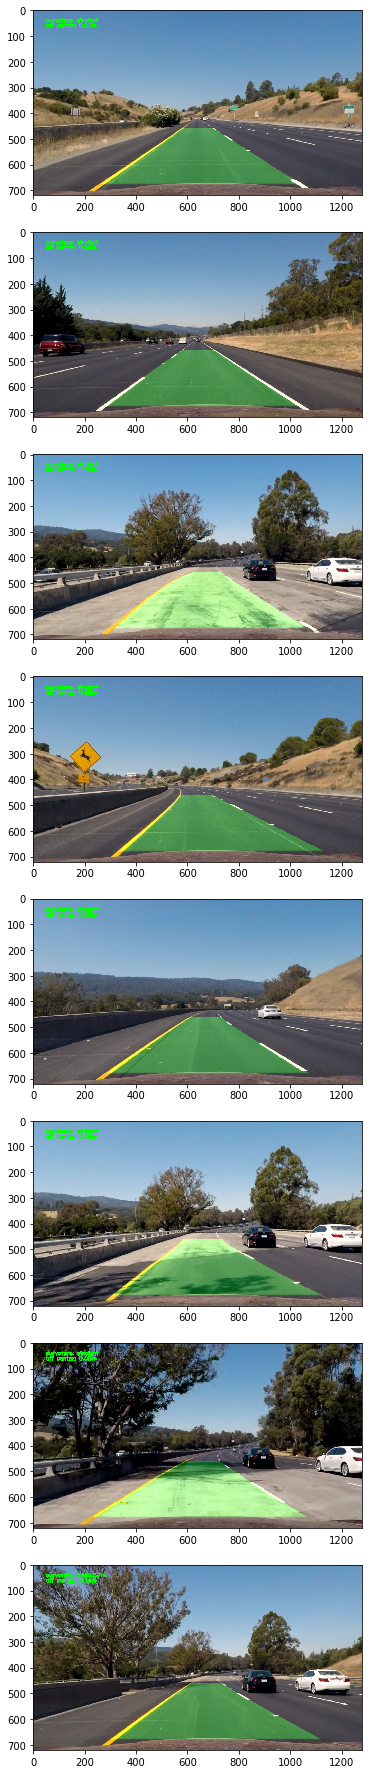

In [332]:
fig, axes = plt.subplots(nrows=len(files), ncols=1)
fig.set_size_inches((16, 32))

for i, file in enumerate(files):
    img = read_img(file)
    img = cv2.resize(img, (1280, 720))
    #filtered_img = color_filter(img)
    #s, d, c, t = p.process(img)
    #print(i)
    result = p.process(img)
    axes[i].imshow(result)
    continue
    axes[i][0].imshow(result[0], cmap='gray')
    axes[i][1].imshow(result[1],  cmap='gray')
    axes[i][2].imshow(result[2],  cmap='gray')
    axes[i][3].imshow(result[3],  cmap='gray')
    continue

In [333]:
def process_challenge(input, output):
    clip1 = VideoFileClip(input)
    white_clip = clip1.fl_image(p.process) 
    %time white_clip.write_videofile(output, audio=False)
    
process_challenge("project_video.mp4", "project_output.mp4")

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [01:11<00:00, 19.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 1min 38s, sys: 2.55 s, total: 1min 40s
Wall time: 1min 12s
